In [ ]:
from google.colab import drive

drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
# ToDo: Need to change folder to your own path 
!unzip -q -o /content/drive/MyDrive/idl_project/Large_Dataset.zip

In [ ]:
!pip install wandb

In [ ]:
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
!pip install seaborn

In [ ]:
import torch
import pdb
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as ttf

import os
import os.path as osp
import os
from typing import List
from typing import Optional

from tqdm import tqdm
from PIL import Image
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import sklearn
import numpy as np
import wandb

import logging

import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn

ROOT_DIR = '/content/Large_Dataset'


def get_file_paths(data_dirs, reskin_file = "reskin_data.csv" ):
    """
    Input: is a ratio of training to validation split. They should sum up to 100 and paths to directories.
    Output: Paths to maintain this split across each class (The main idea being to approximately
    maintain the same ratio. 0 will still be dominant but rest of the classes should be equal in datapoints roughly )
    """
    if(type(data_dirs) == str):
        data_dirs = [data_dirs]
    reskin_paths = {"-1cloth":[],"0cloth":[], "1cloth":[], "2cloth": [], "3cloth": []}
    for data_dir in data_dirs:
        class_dirs = os.listdir(data_dir)
        for class_dir in class_dirs:
            temp = []
            path_dirs = os.listdir(data_dir + "/" + class_dir)
            for path_dir in path_dirs:
                reskin_file_path = data_dir + "/" + class_dir + "/" + path_dir + "/" + reskin_file
                if("0cloth" in class_dir):
                    reskin_paths["0cloth"].append(reskin_file_path)
                elif("1cloth" in class_dir):
                    reskin_paths["1cloth"].append(reskin_file_path)
                elif("2cloth" in class_dir):
                    reskin_paths["2cloth"].append(reskin_file_path)
                elif("3cloth" in class_dir):
                    reskin_paths["3cloth"].append(reskin_file_path)
    return reskin_paths

def get_context(data, context, offset=-1, time_idx = -1, class_idx = -2, include_transition = False, context_type = "double"):
    """
    Input: 2D np array -> raw data from reskin csv file
    Output: dictionary with class followed context values
    """
    res = []
    start_idx = context
    if(context_type == "double"):
        end_idx = data.shape[0] - context - 1
    elif(context_type == "left"):
        end_idx =  data.shape[0]
    else:
        print("Invalid context type")
        return None
    for i in np.arange(start_idx, end_idx, 1):
        
        if(context_type == "double"):
            cur_val = np.array(data[i-context: i+context+1,:])
        elif(context_type == "left"):
            cur_val = np.array(data[i-context:i,:])
        else:
            print("Invalid context type")
            return None
        bool_arr = cur_val[:,class_idx] == cur_val[0,class_idx]
        if(np.all(bool_arr) or include_transition): #Checks if the value is in a transition or not --> For now removing, I can disable this 
            label = int(cur_val[0,class_idx])+offset
            res.append([np.delete(cur_val, [time_idx, class_idx], axis=1), label])
    return res

def std_normalizer(data):
    x_vals = []
    for dat in data:
        x_vals.append(dat[0])
    x_vals = np.hstack(x_vals)
    x_mean  = np.mean(x_vals, axis=0).reshape(1,-1)
    x_std = np.std(x_vals, axis=0).reshape(1,-1)
    for dat in data:
        res_x = np.zeros(dat[0].shape)
        for col in range(dat[0].shape[1]):
            res_x[:,col] = dat[0][:,col] - x_mean[0, col]
            res_x[:,col] = res_x[:,col] /(x_std[0, col]+1e-6)
        dat[0] = res_x
    return data

def get_data(paths):
    data = []
    for path in paths:
        temp = np.loadtxt(path, delimiter=",")
        #pdb.set_trace()
        data.append(temp)
        #print('S',np.shape(temp))
    #pdb.set_trace()
    return data

def setup_paths(data_dirs, train_val_test_split=[0.7, 0.2, 0.1]):
    paths = get_file_paths(data_dirs)
    train_paths = []
    val_paths = []
    test_paths = []
    for key in paths.keys():
      # if(self.shuffle):
      #     random.shuffle(paths[key])
      # else:
      #     pass
      train_num = int(train_val_test_split[0]*len(paths[key]))
      val_num = int(train_val_test_split[1]*len(paths[key]))
      train_paths+=paths[key][:train_num]
      val_paths+=paths[key][train_num:train_num+val_num]
      test_paths+=paths[key][train_num+val_num:]
    
    return train_paths, val_paths, test_paths

class ClothDataSet(Dataset):
    def __init__(self, paths, transforms, context = 5, normalizer = std_normalizer, get_context = get_context, label_offset = -1,
    time_idx = -1, class_idx = -2, include_transition = False, context_type = "double", shuffle=True):
        self.paths = paths
        self.transforms = transforms
        self.normalizer = std_normalizer
        self.get_context = get_context
        self.label_offset = label_offset
        self.time_idx = time_idx
        self.class_idx = class_idx
        self.include_transition = include_transition
        self.context_type = context_type
        self.data = 0
        self.shuffle = shuffle
        self.context = context
        self.setup()

    def setup(self):
        """
        store it in an array of arrays [[ x, y], [x, y] and so] x is a 2D Array btw, 
        normalize the entire dataset (only x)
        shuffle the data completely (shuffling within a particular dataset is fine, just not across datasets)
        store it in some variable
        """
        self.data = get_data(self.paths)
        temp = []
        for data in self.data:
            temp=temp+get_context(data, self.context, self.label_offset, self.time_idx, self.class_idx, self.include_transition, self.context_type)
        self.data = temp
        self.data = self.normalizer(self.data)
        if(self.shuffle):
            random.shuffle(self.data)
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        """
        Think of what data augmentations you want to perform before finally outputting your code
        """
        #TODO perform transforms
        return self.data[idx]


if(__name__ == "__main__"):
    dirn = str(ROOT_DIR) 
    res = get_file_paths(dirn)
    paths = res["0cloth"]
    ## "0cloth" , "1cloth " , "2cloth" , "3cloth"
    #print(paths)
    # dat = get_data(res["0cloth"])
    # temp = []
    # for data in dat:
    #     temp=temp+get_context(data, 5)
    # data = temp
    # data = std_normalizer(data)
    data = ClothDataSet(paths, None)
    train_loader = DataLoader(data, batch_size=128,
                          shuffle=True, drop_last=True, num_workers=2)
    


In [ ]:
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
class ClothDataSet(Dataset):
    def __init__(self, paths, transforms, context = 5, normalizer = std_normalizer, get_context = get_context, label_offset = -1,
    time_idx = -1, class_idx = -2, include_transition = False, context_type = "double", shuffle=True):
        self.paths = paths
        self.transforms = transforms
        self.normalizer = std_normalizer
        self.get_context = get_context
        self.label_offset = label_offset
        self.time_idx = time_idx
        self.class_idx = class_idx
        self.include_transition = include_transition
        self.context_type = context_type
        self.data = 0
        self.shuffle = shuffle
        self.context = context
        self.setup()
        self.labels = [-1,0,1,2,3]


    def setup(self):
        """
        store it in an array of arrays [[ x, y], [x, y] and so] x is a 2D Array btw, 
        normalize the entire dataset (only x)
        shuffle the data completely (shuffling within a particular dataset is fine, just not across datasets)
        store it in some variable
        """
        self.data = get_data(self.paths)
        #temp = []
        #for data in self.data:
        #    temp=temp+get_context(data, self.context, self.label_offset, self.time_idx, self.class_idx, self.include_transition, self.context_type)
        #self.data = temp
        #self.data = self.normalizer(self.data)
        #if(self.shuffle):
        #    random.shuffle(self.data)
    def __len__(self):
        # print(len(self.data))
        #print('d0_s', self.data[0])
        return len(self.data)
    
    def __getitem__(self, ind):
        #print('ind',ind)
        d0 = self.data[ind]
        #print(d0.shape)
        X_t = torch.tensor(d0[:])
        X = torch.zeros((X_t.shape[0],15))
        Y = torch.zeros((len(X_t),1))
        for _ in range(len(X_t)):
            X[_][:] = X_t[_][:15]
            Y[_]    = self.labels.index(int(X_t[_][15] - 1)) # weichen: Need to -1 for labels
        #print(X.shape) # TODO: Convert sequence of  phonemes into sequence of Long tensors
        #print(Y.shape)

        X = torch.tensor(X)
        Y = torch.tensor(Y)

        return X, Y
    
    def collate_fn(self,batch):

        batch_x = [x for x,y in batch]
        batch_y = [y for x,y in batch]

        batch_x_pad = pad_sequence(batch_x,batch_first=True)# TODO: pad the sequence with pad_sequence (already imported)
        lengths_x = [len(x) for x in batch_x]# TODO: Get original lengths of the sequence before padding

        batch_y_pad = pad_sequence(batch_y, batch_first=True) # TODO: pad the sequence with pad_sequence (already imported)
        lengths_y = [len(y) for y in batch_y]# TODO: Get original lengths of the sequence before padding

        return batch_x_pad, batch_y_pad, torch.tensor(lengths_x), torch.tensor(lengths_y)


if(__name__ == "__main__"):
    dirn = str(ROOT_DIR) 
    # res = get_file_paths(dirn)
    # paths = res["0cloth"]
    ## "0cloth" , "1cloth " , "2cloth" , "3cloth"
    #print(paths)
    # dat = get_data(res["0cloth"])
    # temp = []
    # for data in dat:
    #     temp=temp+get_context(data, 5)
    # data = temp
    # data = std_normalizer(data)
    # data = ClothDataSet(paths, None)
    # train_loader = DataLoader(data, batch_size=128,collate_fn=data.collate_fn,
    #                       shuffle=True, drop_last=True, num_workers=2)


    batch_size = 128
    train_paths, val_paths, test_paths = setup_paths(dirn, train_val_test_split=[0.7, 0.2, 0.1])

    train_data = ClothDataSet(train_paths, None)
    val_data = ClothDataSet(val_paths, None)
    test_data = ClothDataSet(test_paths, None)

    train_loader = DataLoader(train_data, batch_size=batch_size, collate_fn=train_data.collate_fn, shuffle=True, drop_last=False, num_workers=2)# TODO: Define the train loader. Remember to pass in a parameter (function) for the collate_fn argument 
    val_loader = DataLoader(val_data, batch_size=batch_size, collate_fn=val_data.collate_fn, shuffle=True, drop_last=False, num_workers=1)# TODO: Define the val loader. Remember to pass in a parameter (function) for the collate_fn argument 
    test_loader = DataLoader(test_data, batch_size=batch_size, collate_fn=test_data.collate_fn, shuffle=False, drop_last=False, num_workers=2)# TODO: Define the test loader. Remember to pass in a parameter (function) for the collate_fn argument 

    print("Batch size: ", batch_size)
    print("Train dataset samples = {}, batches = {}".format(train_data.__len__(), len(train_loader)))
    print("Val dataset samples = {}, batches = {}".format(val_data.__len__(), len(val_loader)))
    print("Test dataset samples = {}, batches = {}".format(test_data.__len__(), len(test_loader)))

    print(train_paths)
    print(val_paths)
    print(test_paths)

In [ ]:
for data in train_loader:
    x, y, lx, ly = data # if you face an error saying "Cannot unpack", then you are not passing the collate_fn argument
    print(x.shape, y.shape, lx.shape, ly.shape)
    break

In [ ]:
class Network(nn.Module):

    def __init__(self): # You can add any extra arguments as you wish

        super(Network, self).__init__()

        # Embedding layer converts the raw input into features which may (or may not) help the LSTM to learn better 
        # For the very low cut-off you dont require an embedding layer. You can pass the input directly to the  LSTM
        embedding_layers = \
                  [
                   nn.Conv1d(in_channels=15, out_channels=128, kernel_size=1, stride=1, padding=1),
#                    nn.Conv1d(in_channels=13, out_channels=128, kernel_size=1),
                   nn.BatchNorm1d(128),
                   nn.ReLU(),
                   nn.Dropout(p=0.3),
                   nn.Conv1d(in_channels=128, out_channels=256, kernel_size=1, stride=1, padding=1),
#                    nn.Conv1d(in_channels=128, out_channels=256, kernel_size=1),
                   nn.BatchNorm1d(256),
                   nn.ReLU(),
                   nn.Dropout(p=0.3)
                  ]
              
        self.embedding = nn.Sequential(*embedding_layers)
  
        # self.lstm = nn.LSTM(15,256,1) # TODO: # Create a single layer, uni-directional LSTM with hidden_size = 256
        # self.lstm = nn.LSTM(15, 512, 1, batch_first=True, bidirectional=True, dropout=0.1)
        self.lstm = nn.LSTM(256, 512, 1, batch_first=True, bidirectional=True, dropout=0.1)
        # Use nn.LSTM() Make sure that you give in the proper arguments as given in https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
        # layers = [nn.Linear(256,5)]
        linear_layers = [nn.Linear(512*2, 2048),
                         nn.ReLU(),
                         nn.Dropout(p=0.3),
                         nn.Linear(2048, 5)]
        self.classification = nn.Sequential(*linear_layers)# TODO: Create a single classification layer using nn.Linear()

        # self.classification = nn.Sequential(*layers)# TODO: Create a single classification layer using nn.Linear()

    def forward(self, x,len_x): # TODO: You need to pass atleast 1 more parameter apart from self and x
        # print(f"x shape{x.shape} len {len_x}")

        x_cnn_in = x.permute(0, 2, 1) #(B, T, 13) -> (B, 13, T)
        # 
        # print(f"cnn in {x_cnn_in.shape}")
        x_cnn_out = self.embedding(x_cnn_in) #(B, Emb_out, T)
        # print(f"cnn out {x_cnn_out.shape}")
        x_lstm_in = x_cnn_out.permute(0, 2, 1) # (B, T, Emb_out)
        # print(f"lstm_in {x_lstm_in.shape}")
        x_origin_len = torch.clamp(len_x,max=x_lstm_in.shape[1])
        # print(f"x_origin_len {x_origin_len}")
        # x is returned from the dataloader. So it is assumed to be padded with the help of the collate_fn
        packed_input = pack_padded_sequence(x_lstm_in, x_origin_len, enforce_sorted=False, batch_first=True)# TODO: Pack the input with pack_padded_sequence. Look at the parameters it requires
        # print(f"packed_input {packed_input.size()}  {x_origin_len}")
        out1, (out2, out3) = self.lstm(packed_input)# TODO: Pass packed input to self.lstm
        # print(f"packed_inout1put {out1.shape}")
        # As you may see from the LSTM docs, LSTM returns 3 vectors. Which one do you need to pass to the next function?
        out, lengths  = pad_packed_sequence(out1, batch_first=True)# TODO: Need to 'unpack' the LSTM output using pad_packed_sequence
        # print(f"out pad {out.shape}")
        out = self.classification(out)# TODO: Pass unpacked LSTM output to the classification layer
        # print(f"out final {out.shape}")
        #out_l =  torch.nn.LogSoftmax(dim=2)(out)# Optional: Do log softmax on the output. Which dimension?

        return out,lengths # TODO: Need to return 2 variables


In [ ]:
model = Network().to("cuda")
criterion = torch.nn.CrossEntropyLoss()
print(model)
for i, data in enumerate(train_loader, 0):
    
    # Write a test code do perform a single forward pass and also compute the Levenshtein distance
    # Make sure that you are able to get this right before going on to the actual training
    # You may encounter a lot of shape errors
    # Printing out the shapes will help in debugging
    # Keep in mind that the Loss which you will use requires the input to be in a different format and the decoder expects it in a different format
    # Make sure to read the corresponding docs about it

    x, y, lx, ly = data
    x = x.cuda()
    y = y.cuda()
    #y = y.transpose(0,1)
    # y = y.reshape((y.shape[0],y.shape[1]))
    out,h = model.forward(x,lx)
    # print(out.shape)
    # print(y.shape)
    # lx = lx.cpu()
    y = torch.tensor(y,dtype = torch.long)
    out = out.reshape((-1,5))
    y = y.reshape((-1))
    loss = criterion(out,y)
    # print(loss)
    del x,y
    torch.cuda.empty_cache()
    #out - L , B  , C
    #pdb.set_trace()

    #break # one iteration is enough

In [ ]:
def val(model, valid_loader, epoch):
    model.eval()
   
    labels = [-1,0,1,2,3]
    true_y_list = []
    pred_y_list = []

    for i, (x, y, lx, ly) in enumerate(val_loader):
      x = x.cuda()
      y = y.cuda()
      # print(x.shape)
      # print(y.shape)

      with torch.no_grad():
          out, length = model(x, lx)
          
          out = out.reshape((-1,5))
          y = y.reshape((-1))
          label_idx = torch.argmax(out, axis=1)
          pred_label = label_idx
          
          pred_y_list.extend(pred_label.tolist())
          true_y_list.extend(y.tolist())
          eval_accuracy =  accuracy_score(true_y_list, pred_y_list)

    print(f"Epoch: {epoch}\t EvaluateACC: {eval_accuracy}\t")
    
    val_metrics = {"epoch":epoch,
             "val_ACC": eval_accuracy}

    wandb.log(val_metrics)
    
    return eval_accuracy

In [ ]:
torch.cuda.empty_cache()
epochs = 100
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)
model = Network().to(device)
print(model)


model.train()
# TODO: Write the model training code 

# You are free to write your own code for training or you can use the code from previous homeworks' starter notebooks
# However, you will have to make modifications because of the following.
# (1) The dataloader returns 4 items unlike 2 for hw2p2
# (2) The model forward returns 2 outputs
# (3) The loss may require transpose or permuting
# scaler = torch.cuda.amp.GradScaler()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 15, gamma=0.7)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=(len(train_loader) * epochs))
criterion = torch.nn.CrossEntropyLoss()

wandb.init(
        project="IDL_Project",
        name="1layer_LSTM_with_2CNN_kernel1",
        config={"epochs": 100,
            "batch_size": 128,
            "lr": 1e-3,
            })

for epoch in range(epochs):
    model.train()
    # Quality of life tip: leave=False and position=0 are needed to make tqdm usable in jupyter
    batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train') 

    num_correct = 0
    total_loss = 0

    for i, data in enumerate(train_loader):
        optimizer.zero_grad()

        # Don't be surprised - we just wrap these two lines to make it work for FP16
        with torch.cuda.amp.autocast():  
            x, y, lx, ly = data
            x = x.cuda()
            y = y.cuda()
            #y = y.transpose(0,1)
            y = y.reshape((y.shape[0],y.shape[1]))
            out,h = model.forward(x,lx)
            # lx = lx.cpu()
            y = torch.tensor(y,dtype = torch.long)
            out = out.reshape((-1,5))
            y = y.reshape((-1))
            loss = criterion(out,y)
            del x,y

        # Update # correct & loss as we go
        #num_correct += int((torch.argmax(outputs, axis=1) == y).sum())
        total_loss += float(loss)

        # tqdm lets you add some details so you can monitor training as you train.
        batch_bar.set_postfix(
            #acc="{:.04f}%".format(100 * num_correct / ((i + 1) * batch_size)),
            loss="{:.04f}".format(float(total_loss / (i + 1))),
            #num_correct=num_correct,
            lr="{:.04f}".format(float(optimizer.param_groups[0]['lr'])))
        
        # Another couple things you need for FP16. 
        #scaler.scale(loss).backward() # This is a replacement for loss.backward()
        #scaler.step(optimizer) # This is a replacement for optimizer.step()
        #scaler.update() # This is something added just for FP16
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #  We told scheduler T_max that we'd call step() (len(train_loader) * epochs) many times.

        batch_bar.update() # Update tqdm bar

    metrics = {"epoch":epoch,
          "train_loss": total_loss / len(train_loader), 
          "train_lr": float(optimizer.param_groups[0]['lr'])}
    
    wandb.log(metrics)
    # torch.save(model,'/content/drive/MyDrive/project.pkl')
    batch_bar.close() # You need this to close the tqdm bar

    # You can add validation per-epoch here if you would like
    scheduler.step()
    print("Epoch {}/{}: , Train Loss {:.04f}, Learning Rate {:.04f}".format(
        epoch + 1,
        epochs,
        float(total_loss / len(train_loader)),
        float(optimizer.param_groups[0]['lr'])))
  
    val(model, val_data, epoch)




In [ ]:
import time
mode = 'train'
model_path = "/content/drive/MyDrive/idl_project/trained_model"
model_name = "LSTM_CNN" + time.strftime("%Y_%m_%d_%H_%M_%S", time.localtime())
torch.save(model.state_dict(),model_path + model_name)
print("save success " + model_name)

save success LSTM_CNN2022_05_02_06_39_21


In [ ]:
model.eval()
labels = [-1,0,1,2,3]
true_y_list = []
pred_y_list = []

for i, (x, y, lx, ly) in enumerate(test_loader):
      x = x.cuda()
      y = y.cuda()
      # print(x.shape)
      # print(y.shape)

      with torch.no_grad():
          out, length = model(x, lx)
          
          out = out.reshape((-1,5))
          y = y.reshape((-1))
          label_idx = torch.argmax(out, axis=1)
          pred_label = label_idx
          
          pred_y_list.extend(pred_label.tolist())
          true_y_list.extend(y.tolist())
          eval_accuracy =  accuracy_score(true_y_list, pred_y_list)

          print(pred_label.shape)
          print(out.shape)
          print(y.shape)
          print(torch.argmax(out))
          print(eval_accuracy)
          

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


torch.Size([40040])
torch.Size([40040, 5])
torch.Size([40040])
tensor(74305, device='cuda:0')
0.9935314685314686


In [ ]:
dirn = str(ROOT_DIR) 
res = get_file_paths(dirn)
paths = res["0cloth"]
# "0cloth" , "1cloth " , "2cloth" , "3cloth"
dat0 = get_data(res["0cloth"])
dat1 = get_data(res["1cloth"])
dat2 = get_data(res["2cloth"])
dat3 = get_data(res["3cloth"])

path0 = res["0cloth"]
path1 = res["1cloth"]
path2 = res["2cloth"]
path3 = res["3cloth"]

# data = std_normalizer(data)

data0 = ClothDataSet(path0, None)
data1 = ClothDataSet(path1, None)
data2 = ClothDataSet(path2, None)
data3 = ClothDataSet(path3, None)

test_loader0 = DataLoader(data0, batch_size=128,collate_fn=data0.collate_fn,
                      shuffle=False, drop_last=True, num_workers=2)
test_loader1 = DataLoader(data1, batch_size=128,collate_fn=data1.collate_fn,
                      shuffle=False, drop_last=True, num_workers=2)
test_loader2 = DataLoader(data2, batch_size=128,collate_fn=data2.collate_fn,
                      shuffle=False, drop_last=True, num_workers=2)
test_loader3 = DataLoader(data3, batch_size=128,collate_fn=data3.collate_fn,
                      shuffle=False, drop_last=True, num_workers=2)




In [ ]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
model.eval()
labels = [-1,0,1,2,3]
true_y_list = []
pred_y_list = []
matrix = []
for i, (x, y, lx, ly) in enumerate(val_loader):
      x = x.cuda()
      y = y.cuda()
      # print(x.shape)
      # print(y.shape)

      with torch.no_grad():
          out, length = model(x, lx)
          
          out = out.reshape((-1,5))
          y = y.reshape((-1))
          label_idx = torch.argmax(out, axis=1)
          pred_label = label_idx
          
          pred_y_list.extend(pred_label.tolist())
          true_y_list.extend(y.tolist())
          eval_accuracy =  accuracy_score(true_y_list, pred_y_list)
          
          matrix = confusion_matrix(true_y_list, pred_y_list, labels=[-1,0,1,2,3], sample_weight=None)
          print(matrix)
          print(pred_label.shape)
          print(out.shape)
          print(y.shape)
          print(torch.argmax(out))
          print(eval_accuracy)




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[[    0     0     0     0     0]
 [    0 32586     7    35   471]
 [    0    10 10387     0     0]
 [    0    19     0 10959     0]
 [    0   372     0     0 10460]]
torch.Size([76356])
torch.Size([76356, 5])
torch.Size([76356])
tensor(119495, device='cuda:0')
0.9856592802137356


(5, 5)
[[32586     7    35   471]
 [   10 10387     0     0]
 [   19     0 10959     0]
 [  372     0     0 10460]]


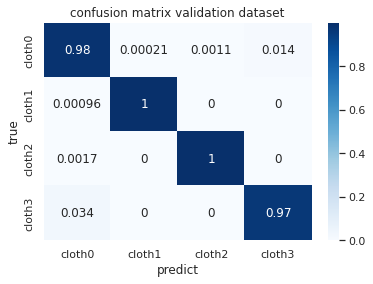

In [ ]:
seaborn.set()
f,ax=plt.subplots()
# y_true = [0,0,1,2,1,2,0,2,2,0,1,1]
# y_pred = [1,0,1,2,1,0,0,2,2,0,1,1]
# C2= confusion_matrix(y_true, y_pred, labels=[-1,0,1,2,3])
print(matrix.shape) 

matrix_plot = matrix[1:, 1:]
cm_normalized = matrix_plot.astype('float') / matrix_plot.sum(axis=1)[:, np.newaxis]

seaborn.heatmap(cm_normalized,annot=True,ax=ax, cmap='Blues') 

ax.xaxis.set_ticklabels(['cloth0','cloth1','cloth2','cloth3'])
ax.yaxis.set_ticklabels(['cloth0','cloth1','cloth2','cloth3'])
ax.set_title('confusion matrix validation dataset') 
ax.set_xlabel('predict') 
ax.set_ylabel('true') 

print(matrix_plot)